# Multi-variate Rregression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

** [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) is an effective regularization technique for this purpose**

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Global variables

In [404]:
N_points = 20 # Number of sample points
# start with small < 40 points and see how the regularized model makes a difference. 
# Then increase the number is see the difference
noise_mult = 50 # Multiplier for the noise term
noise_mean = 10 # Mean for the Gaussian noise adder
noise_sd = 10 # Std. Dev. for the Gaussian noise adder

### Generate feature vectors based on random sampling

In [405]:
X=np.array(10*np.random.randn(N_points,5))

In [406]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [407]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,-7.225627,-16.338843,-1.004751,-14.918569,7.636380
1,2.890603,-8.845838,1.125358,-1.702514,0.520216
2,-4.204175,-6.510710,2.580191,-7.086446,1.287547
3,17.902698,-1.489053,7.723357,-0.782134,2.486191
4,-9.207187,3.090526,-5.448909,-2.728673,11.743763


### Plot the random distributions of input features

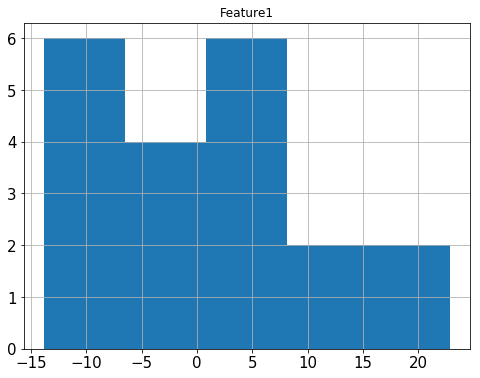

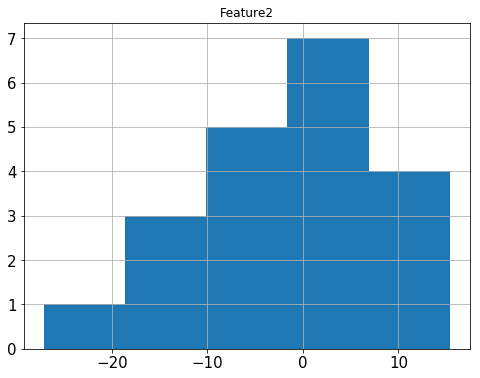

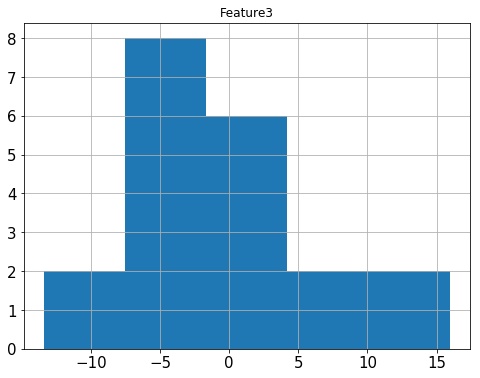

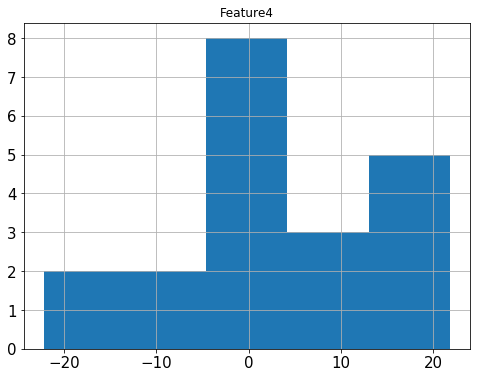

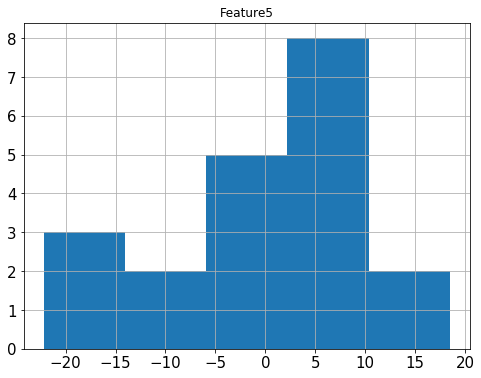

In [408]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

#### Let's construst the ground  truth  or  originating  function  as  follows: 
 
$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x)\ :\ \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$

In [409]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.1*df['Feature3']**2*df['Feature1'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+noise_mult*np.random.normal(loc=noise_mean,scale=noise_sd)

In [410]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,y
0,-7.225627,-16.338843,-1.004751,-14.918569,7.636380,1077.746929
1,2.890603,-8.845838,1.125358,-1.702514,0.520216,477.955253
2,-4.204175,-6.510710,2.580191,-7.086446,1.287547,568.202614
3,17.902698,-1.489053,7.723357,-0.782134,2.486191,2214.375549
4,-9.207187,3.090526,-5.448909,-2.728673,11.743763,1325.224195


### Plot single-variable scatterplots
** It is clear that no clear pattern can be gussed with these single-variable plots **

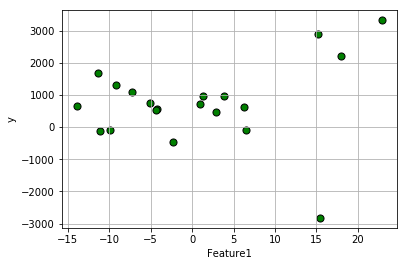

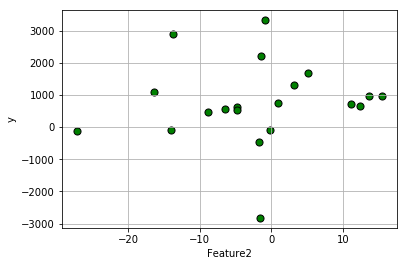

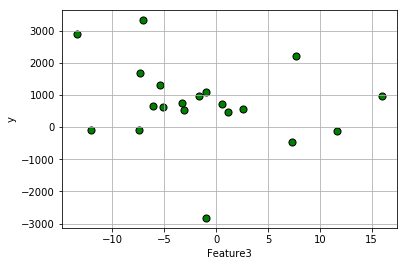

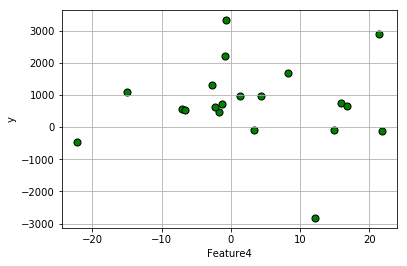

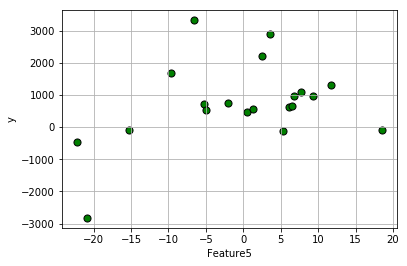

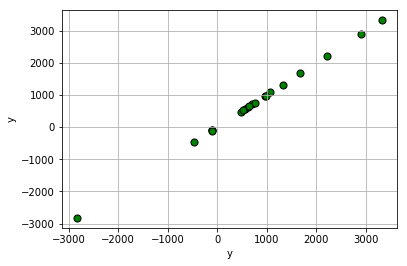

In [411]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True)

### Standard linear regression

In [412]:
from sklearn.linear_model import LinearRegression

In [413]:
linear_model = LinearRegression(normalize=True)

In [414]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']

In [415]:
linear_model.fit(X_linear,y_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [416]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [417]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [418]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 4591.42864942


In [419]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,47.773549
Feature2,5.426572
Feature3,-37.912975
Feature4,-20.471474
Feature5,61.408373


In [420]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.329123897412


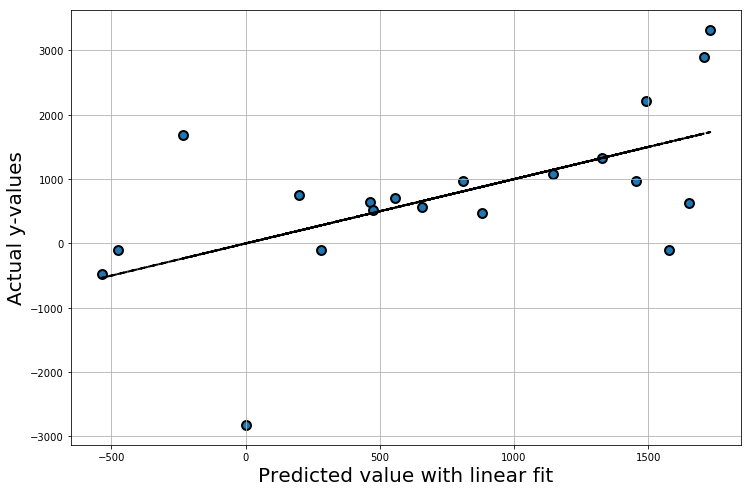

In [421]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [422]:
from sklearn.preprocessing import PolynomialFeatures

In [423]:
poly1 = PolynomialFeatures(3,include_bias=False)

In [424]:
X_poly = poly1.fit_transform(X)
X_poly_feature_name = poly1.get_feature_names(['Feature'+str(l) for l in range(1,6)])
print("The feature vector list:\n",X_poly_feature_name)
print("\nLength of the feature vector:",len(X_poly_feature_name))

The feature vector list:
 ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature1^2', 'Feature1 Feature2', 'Feature1 Feature3', 'Feature1 Feature4', 'Feature1 Feature5', 'Feature2^2', 'Feature2 Feature3', 'Feature2 Feature4', 'Feature2 Feature5', 'Feature3^2', 'Feature3 Feature4', 'Feature3 Feature5', 'Feature4^2', 'Feature4 Feature5', 'Feature5^2', 'Feature1^3', 'Feature1^2 Feature2', 'Feature1^2 Feature3', 'Feature1^2 Feature4', 'Feature1^2 Feature5', 'Feature1 Feature2^2', 'Feature1 Feature2 Feature3', 'Feature1 Feature2 Feature4', 'Feature1 Feature2 Feature5', 'Feature1 Feature3^2', 'Feature1 Feature3 Feature4', 'Feature1 Feature3 Feature5', 'Feature1 Feature4^2', 'Feature1 Feature4 Feature5', 'Feature1 Feature5^2', 'Feature2^3', 'Feature2^2 Feature3', 'Feature2^2 Feature4', 'Feature2^2 Feature5', 'Feature2 Feature3^2', 'Feature2 Feature3 Feature4', 'Feature2 Feature3 Feature5', 'Feature2 Feature4^2', 'Feature2 Feature4 Feature5', 'Feature2 Feature5^2', 'Feature3^3',

In [425]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^3,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3
0,-7.225627,-16.338843,-1.004751,-14.918569,7.636380,52.209690,118.058389,7.259956,107.796020,-55.177633,...,-1.014321,-15.060659,7.709111,-223.621082,114.465099,-58.591340,-3320.331986,1699.580943,-869.965833,445.310095
1,2.890603,-8.845838,1.125358,-1.702514,0.520216,8.355587,-25.569809,3.252962,-4.921294,1.503737,...,1.425186,-2.156115,0.658816,3.261911,-0.996700,0.304549,-4.934832,1.507873,-0.460742,0.140783
2,-4.204175,-6.510710,2.580191,-7.086446,1.287547,17.675091,27.372166,-10.847575,29.792663,-5.413073,...,17.177322,-47.177197,8.571695,129.571299,-23.542003,4.277382,-355.865179,64.657675,-11.747749,2.134466
3,17.902698,-1.489053,7.723357,-0.782134,2.486191,320.506584,-26.658074,138.268928,-14.002300,44.509529,...,460.700154,-46.654456,148.301915,4.724631,-15.018326,47.739203,-0.478457,1.520885,-4.834482,15.367512
4,-9.207187,3.090526,-5.448909,-2.728673,11.743763,84.772288,-28.455054,50.169121,25.123406,-108.127015,...,-161.781416,-81.015972,348.679448,-40.570715,174.609699,-751.491492,-20.316770,87.440046,-376.327608,1619.652276


In [426]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3,y
0,-7.225627,-16.338843,-1.004751,-14.918569,7.636380,52.209690,118.058389,7.259956,107.796020,-55.177633,...,-15.060659,7.709111,-223.621082,114.465099,-58.591340,-3320.331986,1699.580943,-869.965833,445.310095,1077.746929
1,2.890603,-8.845838,1.125358,-1.702514,0.520216,8.355587,-25.569809,3.252962,-4.921294,1.503737,...,-2.156115,0.658816,3.261911,-0.996700,0.304549,-4.934832,1.507873,-0.460742,0.140783,477.955253
2,-4.204175,-6.510710,2.580191,-7.086446,1.287547,17.675091,27.372166,-10.847575,29.792663,-5.413073,...,-47.177197,8.571695,129.571299,-23.542003,4.277382,-355.865179,64.657675,-11.747749,2.134466,568.202614
3,17.902698,-1.489053,7.723357,-0.782134,2.486191,320.506584,-26.658074,138.268928,-14.002300,44.509529,...,-46.654456,148.301915,4.724631,-15.018326,47.739203,-0.478457,1.520885,-4.834482,15.367512,2214.375549
4,-9.207187,3.090526,-5.448909,-2.728673,11.743763,84.772288,-28.455054,50.169121,25.123406,-108.127015,...,-81.015972,348.679448,-40.570715,174.609699,-751.491492,-20.316770,87.440046,-376.327608,1619.652276,1325.224195


In [427]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [428]:
poly2 = LinearRegression(normalize=True)

In [429]:
model_poly=poly2.fit(X_train,y_train)
y_poly = poly2.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 1.64850814918e-11


### The non-regularized polunomial model (notice the coeficients are not learned properly)
** Recall that the originating  function  is: ** 
$ y= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+noise $

In [430]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,-3.527612
Feature2,15.218753
Feature3,-6.994873
Feature4,-1.082630
Feature5,8.141034
Feature1^2,3.042065
Feature1 Feature2,-0.260235
Feature1 Feature3,0.971001
Feature1 Feature4,-0.235444
Feature1 Feature5,0.801043


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [431]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [432]:
from sklearn.linear_model import LassoCV

In [433]:
model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)

In [434]:
model1.fit(X_train,y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=5000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=0)

In [435]:
y_pred1 = np.array(model1.predict(X_train))

In [436]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 14.6011217949


In [437]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,0.000000
Feature2,12.773765
Feature3,-0.000000
Feature4,0.000000
Feature5,0.000000
Feature1^2,4.967681
Feature1 Feature2,-0.000000
Feature1 Feature3,-0.000000
Feature1 Feature4,-0.000000
Feature1 Feature5,0.000000


In [438]:
model1.score(X_train,y_train)

0.99999321548058273

In [439]:
model1.alpha_

0.21965889699484506

### Printing only the non-zero coefficients of the regularized model (notice the coeficients are learned well enough)
** Recall that the originating  function  is: ** 
$ y= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+noise $

In [440]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature2,12.773765
Feature1^2,4.967681
Feature3^2,0.000116
Feature4 Feature5,1.931189
Feature5^2,-0.019570
Feature1^3,0.000897
Feature1^2 Feature3,-0.000761
Feature1 Feature3^2,0.103872
Feature1 Feature4 Feature5,0.792031
Feature1 Feature5^2,-0.007740


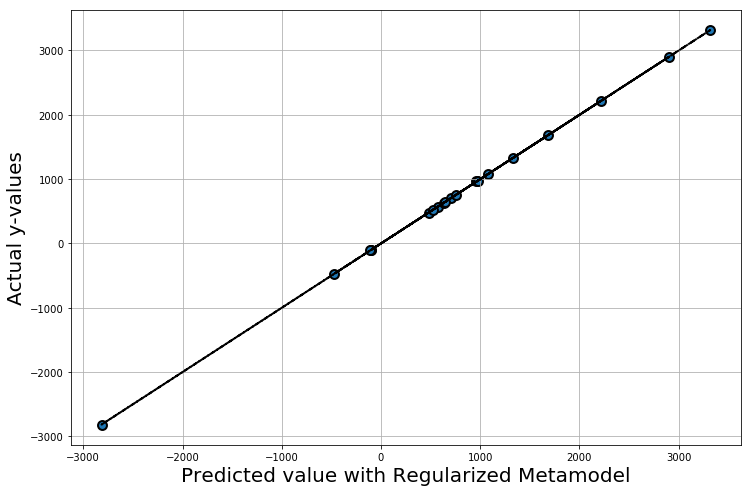

In [441]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Regularized Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)